## Dataset loading and visualization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import edf

dataset = np.load('2d_pcl_dataset.npz')
X, y = dataset['X'], dataset['y']

X0 = X[y==0] # 50 2D points have label 0
X1 = X[y==1] # 50 2D points have label 1


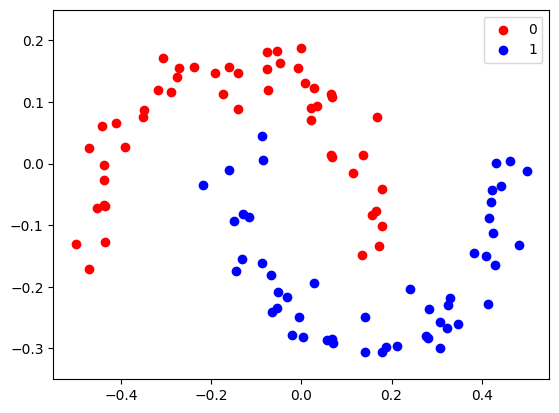

<Figure size 640x480 with 0 Axes>

In [2]:

def plot(X0, X1, fit_param=None):
    plt.scatter(X0[:,0], X0[:,1], color='red', label=0)
    plt.scatter(X1[:,0], X1[:,1], color='blue', label=1)
    
    plt.xlim([-0.55, 0.55])
    plt.ylim([-0.35, 0.25])
    plt.legend()
    plt.show()
    plt.clf()

plot(X0, X1)

In [3]:
# Provide the function that you need 
class SingleProbToProbVector(edf.CompNode):
    def __init__(self, z):
        edf.CompNodes.append(self)
        self.z = z

    def forward(self):
        self.value = np.repeat(self.z.value, 2, axis=1)
        self.value[:, 1] = 1 - self.value[:, 1]

    def backward(self):
        self.z.addgrad((self.grad[:, 0] - self.grad[:, 1]).reshape(-1, 1))

### Logistic Regression based on EDF for the point cloud classification task
Use EDF to assemble a computational graph for logistic regression with the 2D points shown above as input. You will need the `SingleProbToProbVector` provided above. The function `train` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined. `prob_node` calculates the class probabilities, while the `loss_node` calculates the loss for the entire training batch, where you should use `CrossEntropyLoss`.

Hint: You can reuse your code from exercise 1, but now the inputs are now two-dimensional (2D points)

In [4]:
import edf
edf.clear_compgraph()

# TO-DO: add your code below
x_node = edf.Input() 
y_node = edf.Input()

# 构建模型
# Affine transformation (linear layer)
affine_params  = edf.AffineParams(X.shape[1], 1)  # n_features -> 1 (single output for binary classification)
affine_node = edf.Affine(affine_params , x_node)

# Sigmoid activation for probability prediction
sigmoid_node = edf.Sigmoid(affine_node)
prob_node = SingleProbToProbVector(sigmoid_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)  # 根据计算图连接模型节点

In [5]:
def train(num_steps, x, y, x_node, y_node, prob_node, loss_node):
    x_node.value = x
    y_node.value = y
    dataset_size = x.shape[0]

    for iteration in range(1, num_steps + 1):
        edf.Forward()
        total_err = np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))
        edf.Backward(loss_node)
        edf.UpdateParameters()
        
        if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
            print('iter: {}, error: {:6f}'.format(iteration, total_err))
        # print(loss_node.value.mean())

Now train your network

In [6]:
np.random.seed(1234)

num_steps = 100000
learning_rate = 1
edf.learning_rate = learning_rate
train(num_steps, X, y, x_node, y_node, prob_node, loss_node)

iter: 100, error: 18.000000
iter: 200, error: 16.000000
iter: 500, error: 13.000000
iter: 1000, error: 13.000000
iter: 5000, error: 13.000000
iter: 10000, error: 13.000000
iter: 20000, error: 13.000000
iter: 30000, error: 13.000000
iter: 40000, error: 13.000000
iter: 50000, error: 13.000000
iter: 60000, error: 13.000000
iter: 70000, error: 13.000000
iter: 80000, error: 13.000000
iter: 90000, error: 13.000000
iter: 100000, error: 13.000000


Now plot your result below. You should fill the `output` with your trained logistic model.

Hint: you can re-use your code when assembling the computational graph, but remove `SingleProbToProbVector`.

In [7]:
affine_params.A.value, affine_params.b.value

(array([[-4.154005],
        [16.675352]], dtype=float32),
 array([1.0914197], dtype=float32))

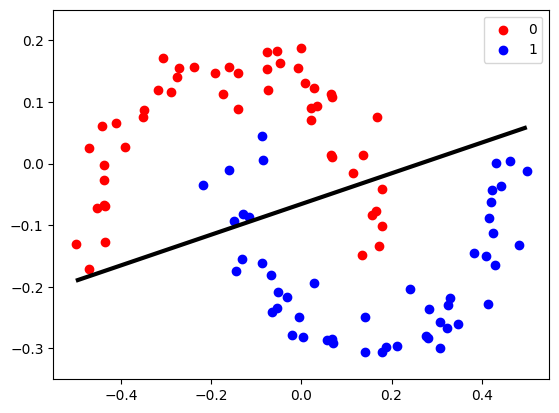

<Figure size 640x480 with 0 Axes>

In [8]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
edf.clear_compgraph()
input = edf.Parameter(X_plot)

#To-DO: fill code here
# output = ...
affine_node = edf.Affine(affine_params, input)
output = edf.Sigmoid(affine_node)
edf.Forward()
edf.Backward(output)

output = output.value.reshape(x_plot.shape[0], x_plot.shape[1])
plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)



### Implement your first multi-layer perceptron (MLP) for point cloud classification
Now you should notice that your logistic regression model cannot classify correctly, and this was taught in Lecture 3.2.  
Therefore, we now ask you to implement an MLP for the same binary classification task.

Again, you need to define `x_node`, `y_node`, `prob_node` and `loss_node` below.

Hint: unlike logistic regression where you need only one affine layer, here you will have two affine layers. After the first affine layer, we also apply a Sigmoid function. The output is then passed to another affine layer followed by another Sigmoid function that directly outputs the final probability. Note that you should use `nHiddens` below as the hidden dimension of your affine payers. If it is not clear to you, check the slide of Lecture 3.


In [24]:
edf.clear_compgraph()
nHiddens = 24

# TO-DO: add your code below
x_node = edf.Input() 
y_node = edf.Input()

# 构建模型
# Affine transformation (linear layer) FOR ALL HIDEN LAYERS
hidden_layer_params   = edf.AffineParams(X.shape[1], nHiddens)  # n_features -> 1 (single output for binary classification)
hidden_affine_node  = edf.Affine(hidden_layer_params , x_node)
hidden_activation_node  = edf.Sigmoid(hidden_affine_node)

# HIDEN LAYERS TO OUTPUT LAYER
output_layer_params = edf.AffineParams(nHiddens, n_outputs)  # 隐藏层到输出层的权重和偏置
output_affine_node = edf.Affine(output_layer_params, hidden_activation_node) # 仿射变换
output_sig_node = edf.Sigmoid(output_affine_node)                  # 输出层的 Sigmoid 激活，用于二分类概率

#PROBABILITY TO VECTOR AND LOSS
prob_node = SingleProbToProbVector(output_sig_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)  # 根据计算图连接模型节点

In [25]:
# Run again
np.random.seed(1234)

num_steps = 100000
learning_rate = 1
edf.learning_rate = learning_rate
train(num_steps, X, y, x_node, y_node, prob_node, loss_node)

iter: 100, error: 16.000000
iter: 200, error: 13.000000
iter: 500, error: 13.000000
iter: 1000, error: 13.000000
iter: 5000, error: 13.000000
iter: 10000, error: 0.000000
iter: 20000, error: 0.000000
iter: 30000, error: 0.000000
iter: 40000, error: 0.000000
iter: 50000, error: 0.000000
iter: 60000, error: 0.000000
iter: 70000, error: 0.000000
iter: 80000, error: 0.000000
iter: 90000, error: 0.000000
iter: 100000, error: 0.000000


Again plot your result. You should fill the `output` with your trained MLP model.

Hint: the `output` should be your `prob_node`, but the `x_node` should be replaced by `input`, and remove `SingleProbToProbVector`.

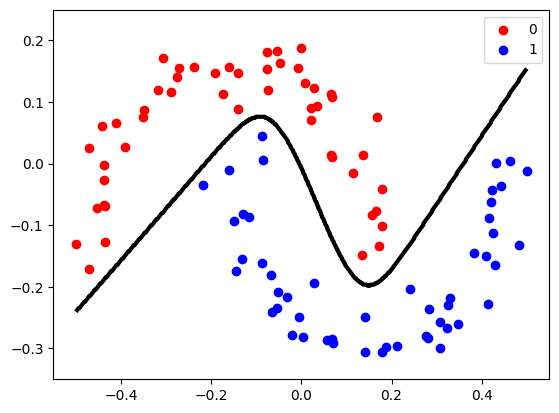

<Figure size 640x480 with 0 Axes>

In [26]:
p = np.linspace(-0.5, 0.5, 500)
x_plot, y_plot = np.meshgrid(p, p)
X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)
edf.clear_compgraph()
input = edf.Parameter(X_plot)

#To-DO: fill code here
# output = ...

hidden_affine_node = edf.Affine(hidden_layer_params, input)
hidden_activation_node = edf.Sigmoid(hidden_affine_node)
output_affine_node = edf.Affine(output_layer_params, hidden_activation_node)
output = edf.Sigmoid(output_affine_node)

edf.Forward()
edf.Backward(output)

output = np.round(output.value).reshape(x_plot.shape[0], x_plot.shape[1])
plt.contour(x_plot, y_plot, output, [0.5],
                  colors=('k',),
                  linewidths=(3,))
plot(X0, X1)
